### Run the next cell first, to be in the correct direcotry

In [1]:
import os

p = os.getcwd()
d = "autoencodix_package"
if d not in p:
    raise FileNotFoundError(f"'{d}' not found in path: {p}")
os.chdir(os.sep.join(p.split(os.sep)[: p.split(os.sep).index(d) + 1]))
print(f"Changed to: {os.getcwd()}")

Changed to: /Users/maximilianjoas/development/autoencodix_package


### Test Data With Varix

In [2]:
import autoencodix as acx
from autoencodix.configs import VarixConfig
from autoencodix.configs.default_config import DataInfo, DataConfig, DataCase

sc_path = os.path.join("data/raw", "GSE84133_human_combined_final.h5ad")
config = VarixConfig(
    epochs=50,
    checkpoint_interval=10,
    batch_size=64,
    data_config=DataConfig(
        annotation_columns=["multi_sc:assigned_cluster"],
        data_info={
            "multi_sc": DataInfo(
                file_path=sc_path, is_single_cell=True, data_type="NUMERIC"
            )
        },
    ),
    data_case=DataCase.MULTI_SINGLE_CELL,
)
varix = acx.Varix(config=config)

In [3]:
result = varix.run()

Number of common cells: 8569
Index(['barcode', 'assigned_cluster', 'sample_id'], dtype='object')
mudata: View of MuData object with n_obs × n_vars = 8569 × 20125
  obs:	'barcode', 'assigned_cluster', 'sample_id'
  1 modality
    multi_sc:	8569 x 20125
      obs:	'barcode', 'assigned_cluster', 'sample_id'
Processing 1 MuData objects: ['multi_sc']
Processing train modality: multi_sc
Processing valid split
Processing valid modality: multi_sc
Processing test split
Processing test modality: multi_sc
Epoch 1 - Train Loss: 23.4961
Sub-losses: recon_loss: 23.4961, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 18.7699
Sub-losses: recon_loss: 18.7699, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 18.5444
Sub-losses: recon_loss: 18.5435, var_loss: 0.0008, anneal_factor: 0.0001, effective_beta_factor: 0.0000
Epoch 2 - Valid Loss: 17.5541
Sub-losses: recon_loss: 17.5540, var_loss: 0.0002, anneal_factor: 0.

Creating plots ...


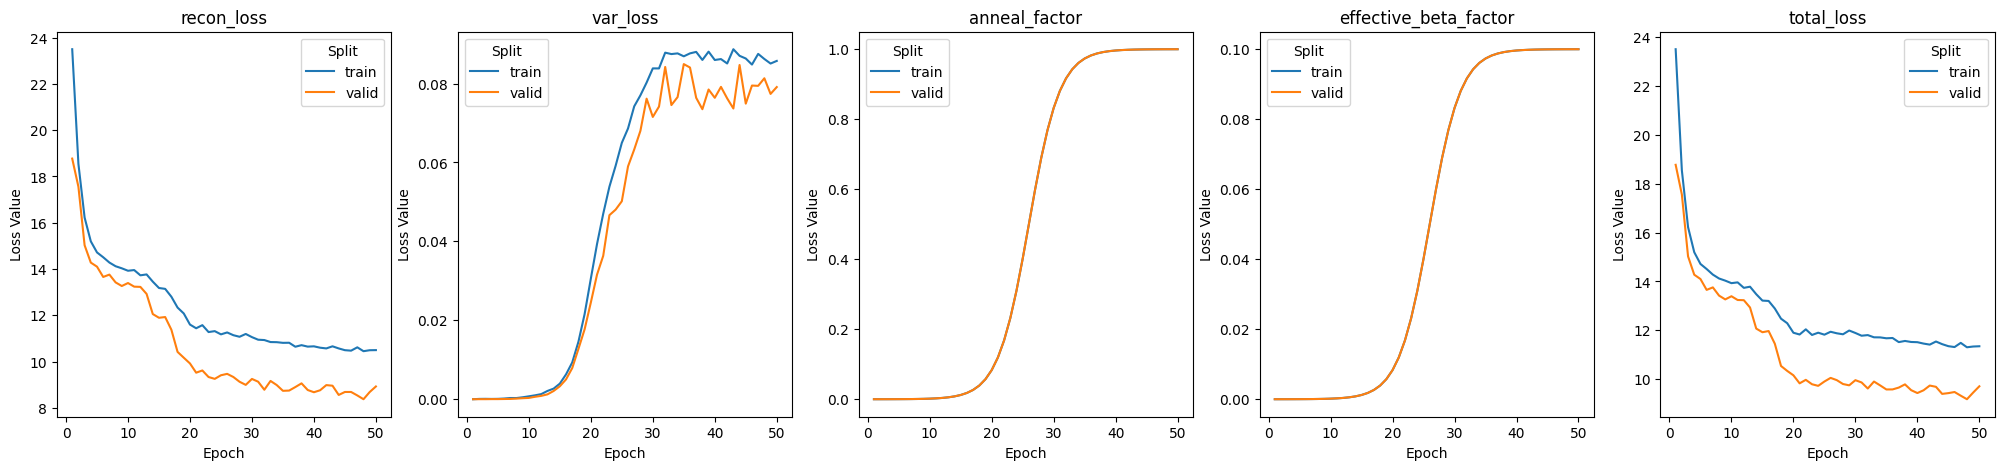

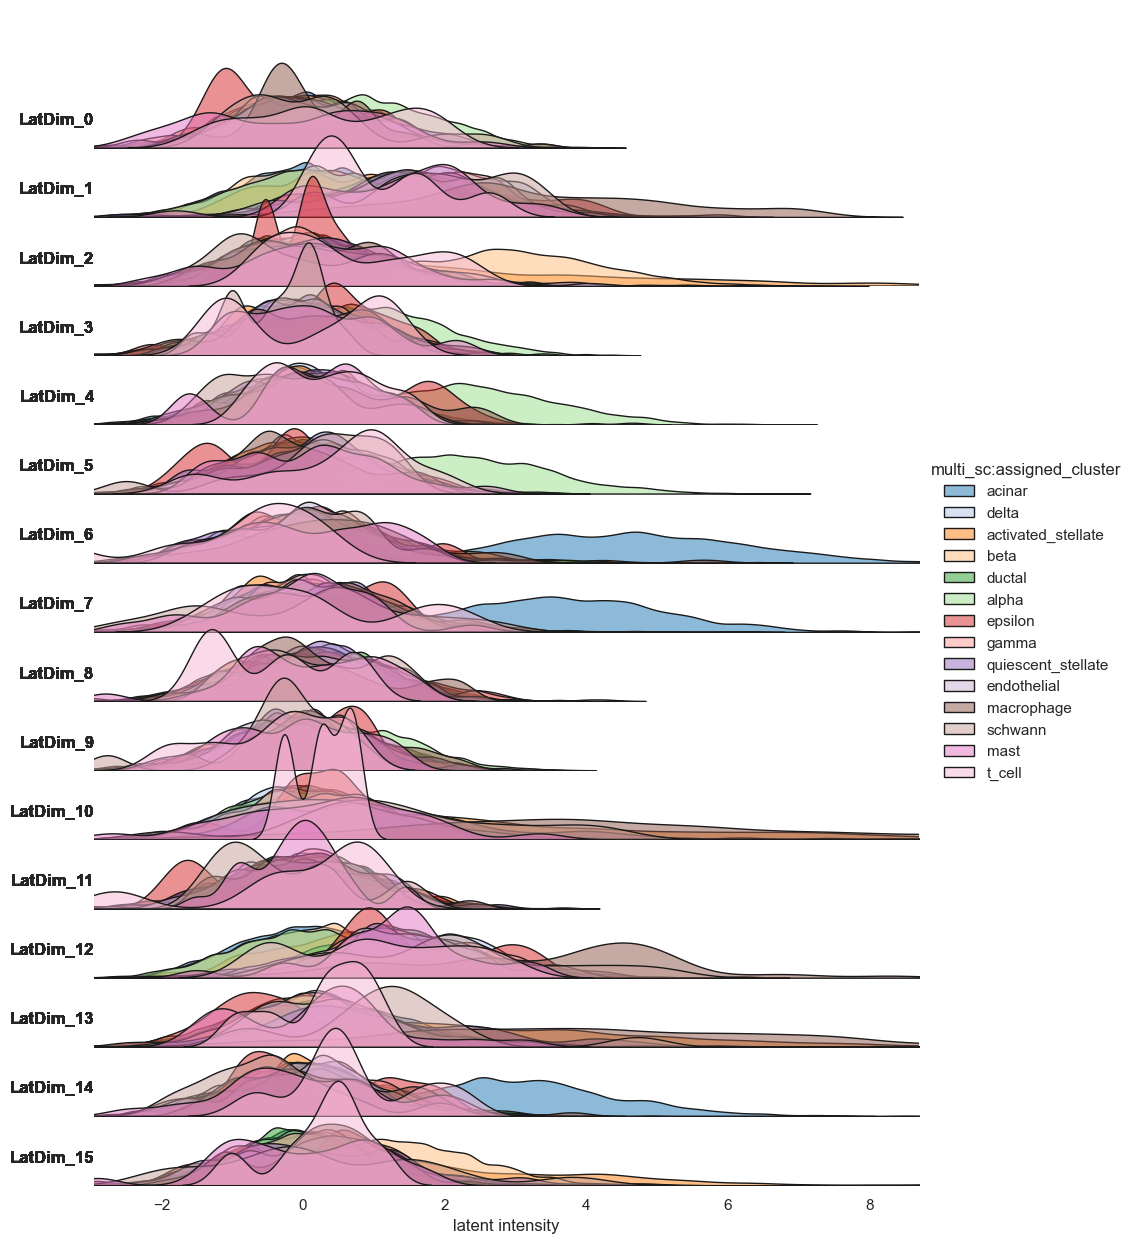

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


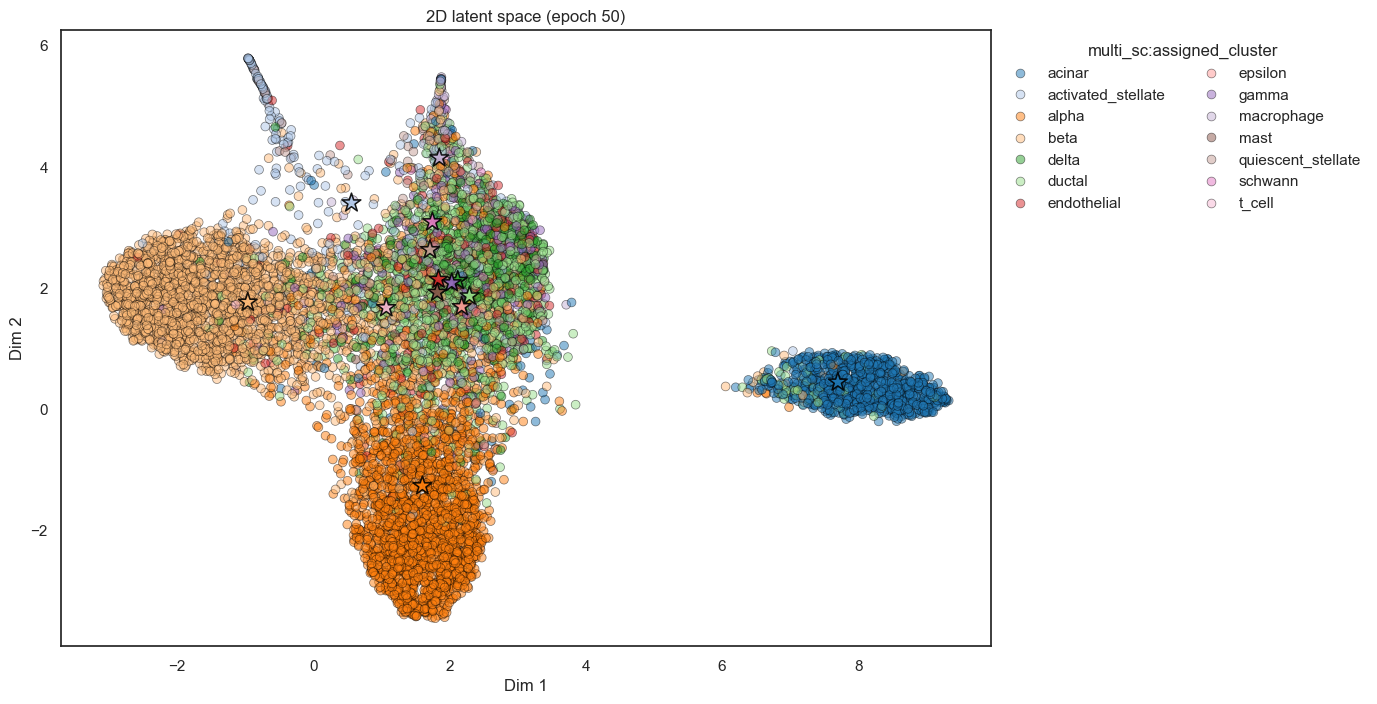

In [4]:
varix.show_result()

#### Potential Bug in Paper
The authors write their shuffle the samples independent per gene, but the code suggests dependent shuffling, see below.

In [5]:
for _, batch, _ in varix._trainer._trainloader:
    print(batch)
    break

tensor([[ 0.6991, -0.2237, -0.4997,  ..., -0.7588, -0.1976, -0.0377],
        [-0.5518, -0.2627,  0.4752,  ..., -0.7788, -0.2832,  0.7294],
        [-0.5778, -0.2837, -0.5049,  ...,  1.5560, -0.2832, -0.9688],
        ...,
        [-0.5828, -0.2837, -0.5049,  ...,  1.8580, -0.2368, -0.8424],
        [-0.5198, -0.2837, -0.3618,  ...,  0.0924,  5.3906, -0.7906],
        [-0.5746, -0.2559,  0.2083,  ..., -0.4270, -0.1854,  0.4692]],
       device='mps:0')


In [6]:
import torch


def apply_noise(X, p=[0.2, 0.4]):
    p = torch.tensor(p)
    should_swap = torch.bernoulli(p.to(X.device) * torch.ones((X.shape)).to(X.device))
    permut = torch.randperm(X.shape[0])
    print(permut)
    corrupted_X = torch.where(should_swap == 1, X[permut], X)
    print(corrupted_X)
    masked = (corrupted_X != X).float()
    return corrupted_X, masked


In [7]:
batch.shape

torch.Size([64, 20])

In [8]:
batch

tensor([[ 0.6991, -0.2237, -0.4997,  ..., -0.7588, -0.1976, -0.0377],
        [-0.5518, -0.2627,  0.4752,  ..., -0.7788, -0.2832,  0.7294],
        [-0.5778, -0.2837, -0.5049,  ...,  1.5560, -0.2832, -0.9688],
        ...,
        [-0.5828, -0.2837, -0.5049,  ...,  1.8580, -0.2368, -0.8424],
        [-0.5198, -0.2837, -0.3618,  ...,  0.0924,  5.3906, -0.7906],
        [-0.5746, -0.2559,  0.2083,  ..., -0.4270, -0.1854,  0.4692]],
       device='mps:0')

In [9]:
apply_noise(batch, p=0.4)

tensor([ 3, 57, 18,  0, 13, 17, 30, 11,  5, 44, 24, 48, 41, 25, 63, 42, 51, 43,
        36,  9,  7, 45, 56, 55, 47, 22, 15, 58, 38, 32, 10, 31, 62, 60, 14, 40,
        27, 20, 46, 19, 34, 28, 16, 52, 29, 23,  6, 53, 54, 26, 59, 50, 12, 37,
         4, 39, 35, 49,  2,  1, 61,  8, 21, 33])
tensor([[ 0.6991, -0.2237, -0.5019,  ..., -0.7588, -0.1976, -0.0377],
        [-0.5518, -0.2627,  0.4752,  ..., -0.7788, -0.2832,  0.7294],
        [-0.5778, -0.2837, -0.5049,  ..., -0.6884,  2.5330, -0.9688],
        ...,
        [-0.5828,  5.2202, -0.4653,  ..., -0.6305, -0.2368, -0.8424],
        [-0.5198, -0.2837, -0.5049,  ..., -0.5600,  0.2314, -0.7906],
        [-0.5746, -0.2514,  0.3185,  ..., -0.4270, -0.1128,  0.4692]],
       device='mps:0')


(tensor([[ 0.6991, -0.2237, -0.5019,  ..., -0.7588, -0.1976, -0.0377],
         [-0.5518, -0.2627,  0.4752,  ..., -0.7788, -0.2832,  0.7294],
         [-0.5778, -0.2837, -0.5049,  ..., -0.6884,  2.5330, -0.9688],
         ...,
         [-0.5828,  5.2202, -0.4653,  ..., -0.6305, -0.2368, -0.8424],
         [-0.5198, -0.2837, -0.5049,  ..., -0.5600,  0.2314, -0.7906],
         [-0.5746, -0.2514,  0.3185,  ..., -0.4270, -0.1128,  0.4692]],
        device='mps:0'),
 tensor([[0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 1., 0.],
         ...,
         [0., 1., 1.,  ..., 1., 0., 0.],
         [0., 0., 1.,  ..., 1., 1., 0.],
         [0., 1., 1.,  ..., 0., 1., 0.]], device='mps:0'))

#### Correction


In [10]:
from typing import List

X = batch
print(f"batch shape: {X.shape}")
mask_probas_list: List[float] = [
    varix.config.maskix_swap_prob
] * varix._trainer._model.input_dim
mask_probas = torch.tensor(mask_probas_list).to(varix._trainer._model.device)
print(f"mask_probas shape: {mask_probas.shape}")


probs = mask_probas.expand(X.shape)
print(f"probs shape after expand: {probs.shape}")

should_swap = torch.bernoulli(probs).bool()

rand_indices = torch.rand(X.shape, device=X.device).argsort(dim=0)
print(f"rand_indices : {rand_indices}")

shuffled_X = torch.gather(X, 0, rand_indices)
print(f"shuffled_X: {shuffled_X}")
corrupted_X = torch.where(should_swap, shuffled_X, X)
print(f"corrupted_X: {corrupted_X}")


batch shape: torch.Size([64, 20])
mask_probas shape: torch.Size([20])
probs shape after expand: torch.Size([64, 20])
rand_indices : tensor([[63, 60, 59,  ..., 24, 42, 18],
        [14, 40, 31,  ..., 30, 16, 19],
        [23, 37, 15,  ..., 50, 51, 21],
        ...,
        [60, 63, 58,  ..., 60, 44, 44],
        [61, 36, 17,  ..., 43, 41, 20],
        [29, 28, 13,  ..., 61, 24, 55]], device='mps:0')
shuffled_X: tensor([[-0.5746, -0.2482, -0.5027,  ...,  0.1101, -0.2832, -0.9038],
        [-0.5828, -0.2510, -0.1677,  ..., -0.5284, -0.1230,  0.6207],
        [ 1.6185, -0.2837, -0.5049,  ...,  0.2919, -0.2494, -0.9032],
        ...,
        [ 2.2949, -0.2559, -0.5049,  ..., -0.7379,  0.0768,  0.4286],
        [-0.5828, -0.2828,  0.5676,  ...,  0.0562, -0.1467, -0.8862],
        [ 2.0098, -0.2118, -0.4959,  ...,  1.8580, -0.2832,  2.9166]],
       device='mps:0')
corrupted_X: tensor([[-0.5746, -0.2237, -0.4997,  ..., -0.7588, -0.1976, -0.9038],
        [-0.5828, -0.2510,  0.4752,  ..., -0.5

In [11]:
import torch

rand_indices = torch.rand(X.shape, device=X.device).argsort(dim=0)
print(f"rand_indices : {rand_indices}")


rand_indices : tensor([[58, 37,  3,  ..., 32, 50, 46],
        [63, 25,  9,  ...,  8,  3, 63],
        [44, 51, 53,  ..., 42, 28,  3],
        ...,
        [26, 39, 44,  ..., 37, 54, 35],
        [28, 46,  5,  ..., 59,  5, 26],
        [31,  8,  4,  ..., 13, 21, 10]], device='mps:0')


In [12]:
rand_indices.shape

torch.Size([64, 20])

In [13]:
shuffled_X = torch.gather(X, 0, rand_indices)

In [14]:
print(f"shuffled_X: {shuffled_X}")

shuffled_X: tensor([[-0.5828, -0.2837, -0.5019,  ...,  5.0916, -0.1142, -0.1137],
        [-0.5746, -0.2754,  0.5433,  ..., -0.6305, -0.2166,  0.4692],
        [ 1.2955, -0.2830, -0.4897,  ..., -0.6258, -0.1061,  1.4065],
        ...,
        [ 0.9094, -0.2767, -0.4995,  ..., -0.0661, -0.2239, -0.1906],
        [ 0.2319, -0.2837, -0.5008,  ...,  0.6002, -0.2603,  0.0758],
        [-0.5802,  5.2202, -0.5049,  ...,  1.9875,  0.2314,  0.1347]],
       device='mps:0')


In [15]:
torch.rand(X.shape, device=X.device)

tensor([[0.5334, 0.2967, 0.0912,  ..., 0.6285, 0.1456, 0.3729],
        [0.8003, 0.2236, 0.6905,  ..., 0.4850, 0.5179, 0.8776],
        [0.0652, 0.0558, 0.7314,  ..., 0.1411, 0.0907, 0.1301],
        ...,
        [0.4415, 0.6278, 0.6947,  ..., 0.4689, 0.5562, 0.5690],
        [0.5882, 0.7259, 0.5022,  ..., 0.8464, 0.2455, 0.8093],
        [0.9810, 0.3230, 0.1187,  ..., 0.0730, 0.6177, 0.3218]],
       device='mps:0')

## Test Maskix Pipeline

In [2]:
import autoencodix as acx
from autoencodix.configs import MaskixConfig
from autoencodix.configs.default_config import DataInfo, DataConfig, DataCase

sc_path = os.path.join("data/raw", "GSE84133_human_combined_final.h5ad")
config = MaskixConfig(
    epochs=50,
    checkpoint_interval=10,
    batch_size=64,
    data_config=DataConfig(
        annotation_columns=["multi_sc:assigned_cluster"],
        data_info={
            "multi_sc": DataInfo(
                file_path=sc_path, is_single_cell=True, data_type="NUMERIC"
            )
        },
    ),
    data_case=DataCase.MULTI_SINGLE_CELL,
)
maskix = acx.Maskix(config=config)

In [17]:
maskix_result = maskix.run()

Number of common cells: 8569
Index(['barcode', 'assigned_cluster', 'sample_id'], dtype='object')
mudata: View of MuData object with n_obs × n_vars = 8569 × 20125
  obs:	'barcode', 'assigned_cluster', 'sample_id'
  1 modality
    multi_sc:	8569 x 20125
      obs:	'barcode', 'assigned_cluster', 'sample_id'
Processing 1 MuData objects: ['multi_sc']
Processing train modality: multi_sc
Processing valid split
Processing valid modality: multi_sc
Processing test split
Processing test modality: multi_sc


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/losses/maskix_loss.py:38: UserWarning: You chose loss reduction: sum, this deviates from the implementation in the literature for this architecture, the authors used 'mean'
  warnings.warn(


Epoch 1 - Train Loss: 9.3339
Sub-losses: recon_loss: 6.4427, mask_loss: 10.5729
Epoch 1 - Valid Loss: 7.1314
Sub-losses: recon_loss: 4.8831, mask_loss: 8.0950
Epoch 2 - Train Loss: 7.0548
Sub-losses: recon_loss: 4.3733, mask_loss: 8.2040
Epoch 2 - Valid Loss: 6.6440
Sub-losses: recon_loss: 3.9379, mask_loss: 7.8037
Epoch 3 - Train Loss: 6.8926
Sub-losses: recon_loss: 3.9467, mask_loss: 8.1551
Epoch 3 - Valid Loss: 6.7395
Sub-losses: recon_loss: 3.8386, mask_loss: 7.9828
Epoch 4 - Train Loss: 6.7569
Sub-losses: recon_loss: 3.8041, mask_loss: 8.0224
Epoch 4 - Valid Loss: 6.5199
Sub-losses: recon_loss: 3.6319, mask_loss: 7.7576
Epoch 5 - Train Loss: 6.7593
Sub-losses: recon_loss: 3.6434, mask_loss: 8.0948
Epoch 5 - Valid Loss: 6.5933
Sub-losses: recon_loss: 3.5385, mask_loss: 7.9026
Epoch 6 - Train Loss: 6.7163
Sub-losses: recon_loss: 3.5633, mask_loss: 8.0677
Epoch 6 - Valid Loss: 6.5932
Sub-losses: recon_loss: 3.6924, mask_loss: 7.8365
Epoch 7 - Train Loss: 6.6579
Sub-losses: recon_loss

Creating plots ...


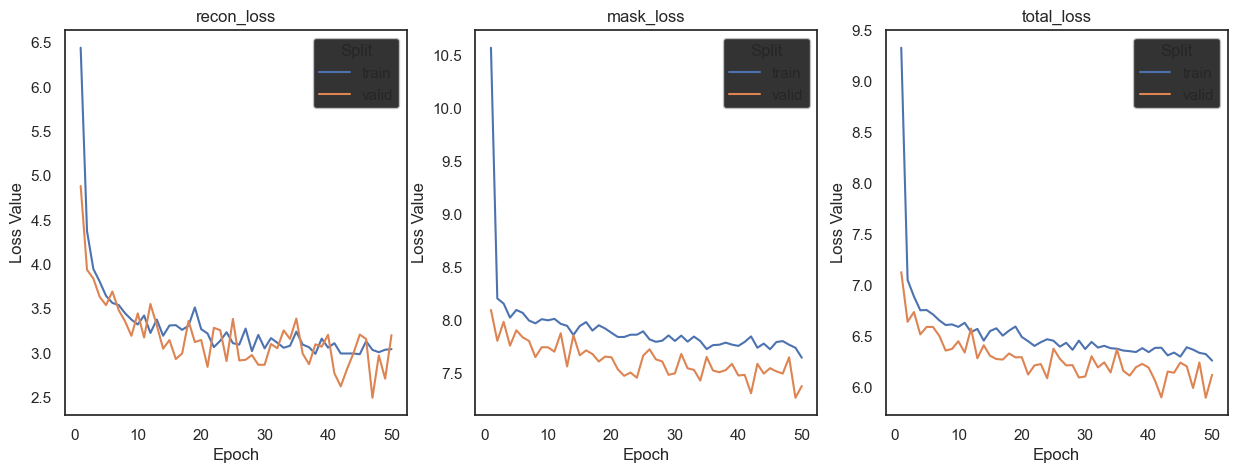

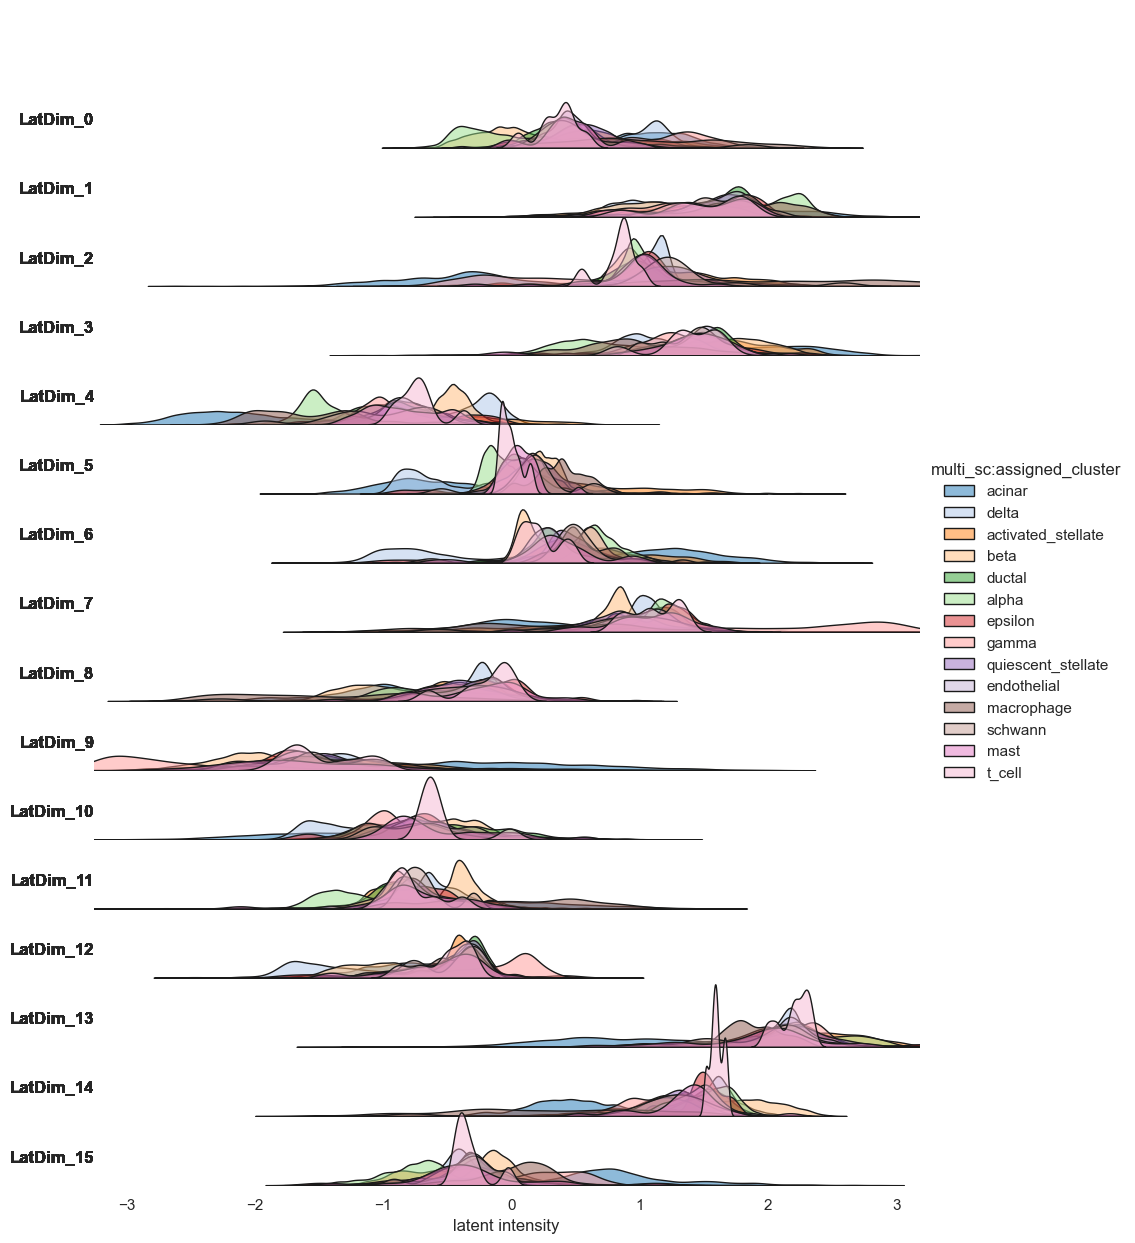

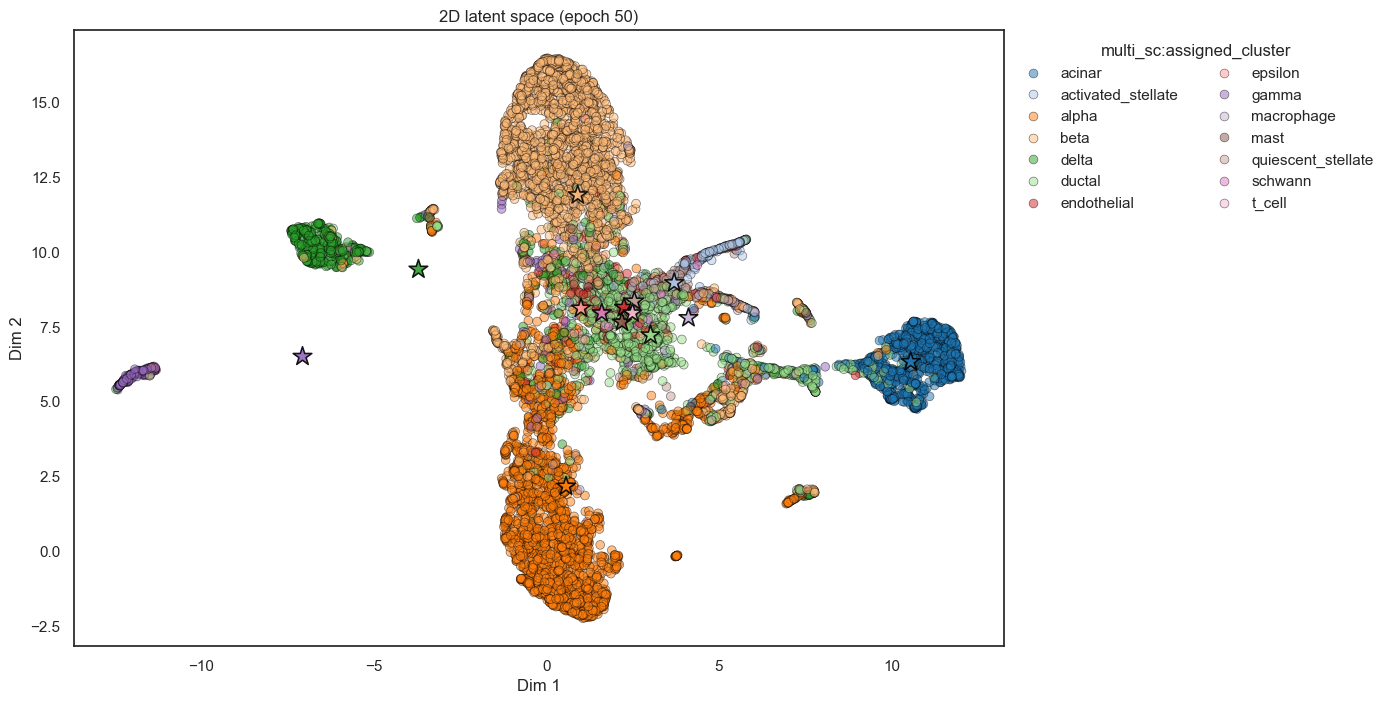

In [18]:
maskix.show_result()

In [19]:
config.latent_dim

16

### Consitency Check
We will gradually increase the probablity of masking, to see if the masking works as intended. We expect the Maskix to be similar to the Vanillix for propabilties near zero and to  be not working at all for probablities near 1

##### Vanillix Baseline


In [20]:
import autoencodix as acx
from autoencodix.data.datapackage import DataPackage
from autoencodix.configs.vanillix_config import VanillixConfig
from autoencodix.configs.default_config import DataCase


config = VanillixConfig(
    epochs=50,
    checkpoint_interval=10,
    batch_size=64,
    data_config=DataConfig(
        annotation_columns=["multi_sc:assigned_cluster"],
        data_info={
            "multi_sc": DataInfo(
                file_path=sc_path, is_single_cell=True, data_type="NUMERIC"
            )
        },
    ),
    data_case=DataCase.MULTI_SINGLE_CELL,
)
vanillix = acx.Vanillix(config=config)

In [21]:
result_vanillix = vanillix.run()

Number of common cells: 8569
Index(['barcode', 'assigned_cluster', 'sample_id'], dtype='object')
mudata: View of MuData object with n_obs × n_vars = 8569 × 20125
  obs:	'barcode', 'assigned_cluster', 'sample_id'
  1 modality
    multi_sc:	8569 x 20125
      obs:	'barcode', 'assigned_cluster', 'sample_id'
Processing 1 MuData objects: ['multi_sc']
Processing train modality: multi_sc
Processing valid split
Processing valid modality: multi_sc
Processing test split
Processing test modality: multi_sc
Epoch 1 - Train Loss: 21.2050
Sub-losses: recon_loss: 21.2050
Epoch 1 - Valid Loss: 16.0688
Sub-losses: recon_loss: 16.0688
Epoch 2 - Train Loss: 15.7474
Sub-losses: recon_loss: 15.7474
Epoch 2 - Valid Loss: 12.8582
Sub-losses: recon_loss: 12.8582
Epoch 3 - Train Loss: 13.6425
Sub-losses: recon_loss: 13.6425
Epoch 3 - Valid Loss: 11.9293
Sub-losses: recon_loss: 11.9293
Epoch 4 - Train Loss: 12.6106
Sub-losses: recon_loss: 12.6106
Epoch 4 - Valid Loss: 10.8533
Sub-losses: recon_loss: 10.8533
Epoc

Creating plots ...


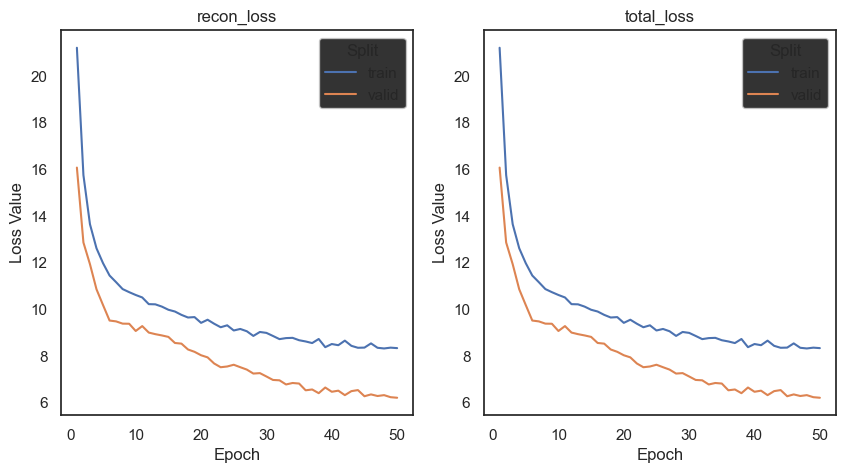

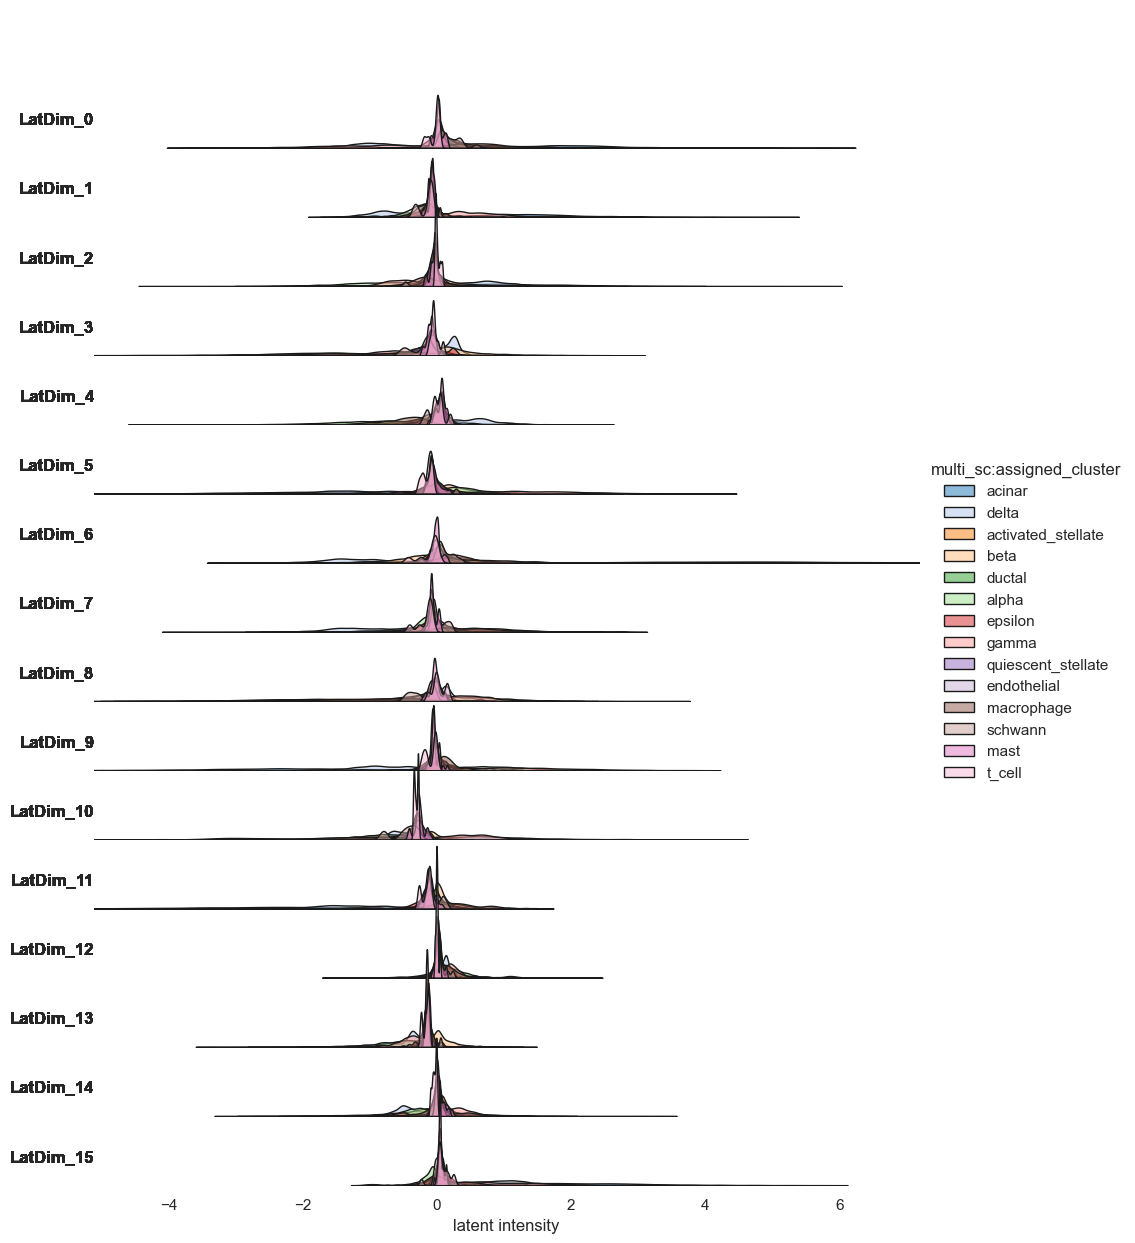

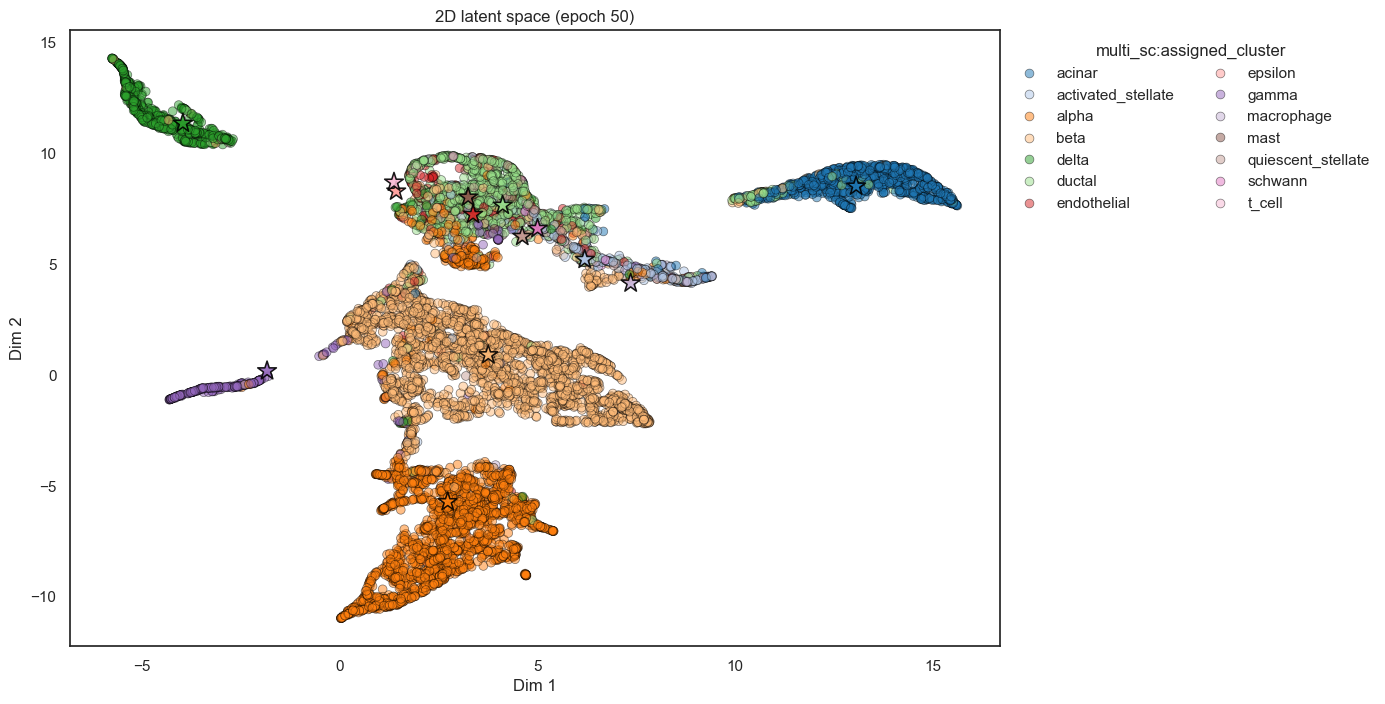

In [22]:
vanillix.show_result()

### Maskix Checks

In [25]:
import autoencodix as acx
from autoencodix.configs import MaskixConfig
from autoencodix.configs.default_config import DataInfo, DataConfig, DataCase


probs = [0.0,0.3,0.6,1.0]
pipelines = {}
for p in probs:
    sc_path = os.path.join("data/raw", "GSE84133_human_combined_final.h5ad")
    config = MaskixConfig(
        epochs=50,
        checkpoint_interval=10,
        batch_size=64,
        maskix_swap_prob=p,
        data_config=DataConfig(
            annotation_columns=["multi_sc:assigned_cluster"],
            data_info={
                "multi_sc": DataInfo(
                    file_path=sc_path, is_single_cell=True, data_type="NUMERIC"
                )
            },
        ),
        data_case=DataCase.MULTI_SINGLE_CELL,
    )
    maskix = acx.Maskix(config=config)
    result = maskix.run()
    pipelines[str(p)] = maskix

Number of common cells: 8569
Index(['barcode', 'assigned_cluster', 'sample_id'], dtype='object')
mudata: View of MuData object with n_obs × n_vars = 8569 × 20125
  obs:	'barcode', 'assigned_cluster', 'sample_id'
  1 modality
    multi_sc:	8569 x 20125
      obs:	'barcode', 'assigned_cluster', 'sample_id'
Processing 1 MuData objects: ['multi_sc']
Processing train modality: multi_sc
Processing valid split
Processing valid modality: multi_sc
Processing test split
Processing test modality: multi_sc


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/losses/maskix_loss.py:38: UserWarning: You chose loss reduction: sum, this deviates from the implementation in the literature for this architecture, the authors used 'mean'
  warnings.warn(


Epoch 1 - Train Loss: 6.5501
Sub-losses: recon_loss: 4.7511, mask_loss: 7.3211
Epoch 1 - Valid Loss: 2.0987
Sub-losses: recon_loss: 3.6242, mask_loss: 1.4449
Epoch 2 - Train Loss: 1.3493
Sub-losses: recon_loss: 3.1161, mask_loss: 0.5921
Epoch 2 - Valid Loss: 0.9343
Sub-losses: recon_loss: 2.5611, mask_loss: 0.2371
Epoch 3 - Train Loss: 0.8095
Sub-losses: recon_loss: 2.3234, mask_loss: 0.1607
Epoch 3 - Valid Loss: 0.6843
Sub-losses: recon_loss: 2.0271, mask_loss: 0.1088
Epoch 4 - Train Loss: 0.6359
Sub-losses: recon_loss: 1.9273, mask_loss: 0.0824
Epoch 4 - Valid Loss: 0.5675
Sub-losses: recon_loss: 1.7419, mask_loss: 0.0642
Epoch 5 - Train Loss: 0.5468
Sub-losses: recon_loss: 1.7030, mask_loss: 0.0513
Epoch 5 - Valid Loss: 0.4763
Sub-losses: recon_loss: 1.4921, mask_loss: 0.0409
Epoch 6 - Train Loss: 0.4927
Sub-losses: recon_loss: 1.5610, mask_loss: 0.0349
Epoch 6 - Valid Loss: 0.4214
Sub-losses: recon_loss: 1.3368, mask_loss: 0.0291
Epoch 7 - Train Loss: 0.4618
Sub-losses: recon_loss:

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/losses/maskix_loss.py:38: UserWarning: You chose loss reduction: sum, this deviates from the implementation in the literature for this architecture, the authors used 'mean'
  warnings.warn(


Epoch 1 - Train Loss: 10.5543
Sub-losses: recon_loss: 7.6369, mask_loss: 11.8046
Epoch 1 - Valid Loss: 8.6516
Sub-losses: recon_loss: 5.3967, mask_loss: 10.0465
Epoch 2 - Train Loss: 8.7588
Sub-losses: recon_loss: 5.3461, mask_loss: 10.2214
Epoch 2 - Valid Loss: 8.4677
Sub-losses: recon_loss: 4.9357, mask_loss: 9.9814
Epoch 3 - Train Loss: 8.5756
Sub-losses: recon_loss: 4.8451, mask_loss: 10.1744
Epoch 3 - Valid Loss: 8.2909
Sub-losses: recon_loss: 4.7723, mask_loss: 9.7988
Epoch 4 - Train Loss: 8.4898
Sub-losses: recon_loss: 4.7780, mask_loss: 10.0806
Epoch 4 - Valid Loss: 8.3244
Sub-losses: recon_loss: 4.7382, mask_loss: 9.8613
Epoch 5 - Train Loss: 8.5137
Sub-losses: recon_loss: 4.7601, mask_loss: 10.1224
Epoch 5 - Valid Loss: 8.1458
Sub-losses: recon_loss: 4.3927, mask_loss: 9.7542
Epoch 6 - Train Loss: 8.4092
Sub-losses: recon_loss: 4.5666, mask_loss: 10.0559
Epoch 6 - Valid Loss: 8.2993
Sub-losses: recon_loss: 4.5929, mask_loss: 9.8878
Epoch 7 - Train Loss: 8.4167
Sub-losses: rec

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/losses/maskix_loss.py:38: UserWarning: You chose loss reduction: sum, this deviates from the implementation in the literature for this architecture, the authors used 'mean'
  warnings.warn(


Epoch 1 - Train Loss: 12.6102
Sub-losses: recon_loss: 10.2170, mask_loss: 13.6359
Epoch 1 - Valid Loss: 11.4402
Sub-losses: recon_loss: 8.2956, mask_loss: 12.7879
Epoch 2 - Train Loss: 11.5809
Sub-losses: recon_loss: 8.5700, mask_loss: 12.8714
Epoch 2 - Valid Loss: 11.1214
Sub-losses: recon_loss: 8.0206, mask_loss: 12.4503
Epoch 3 - Train Loss: 11.4134
Sub-losses: recon_loss: 8.3623, mask_loss: 12.7210
Epoch 3 - Valid Loss: 11.1708
Sub-losses: recon_loss: 8.1374, mask_loss: 12.4709
Epoch 4 - Train Loss: 11.2879
Sub-losses: recon_loss: 8.0709, mask_loss: 12.6666
Epoch 4 - Valid Loss: 10.9766
Sub-losses: recon_loss: 7.7776, mask_loss: 12.3476
Epoch 5 - Train Loss: 11.3063
Sub-losses: recon_loss: 8.2231, mask_loss: 12.6276
Epoch 5 - Valid Loss: 10.9855
Sub-losses: recon_loss: 7.8808, mask_loss: 12.3161
Epoch 6 - Train Loss: 11.2387
Sub-losses: recon_loss: 8.0957, mask_loss: 12.5857
Epoch 6 - Valid Loss: 10.9819
Sub-losses: recon_loss: 7.8714, mask_loss: 12.3149
Epoch 7 - Train Loss: 11.27

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/losses/maskix_loss.py:38: UserWarning: You chose loss reduction: sum, this deviates from the implementation in the literature for this architecture, the authors used 'mean'
  warnings.warn(


Epoch 1 - Train Loss: 13.4405
Sub-losses: recon_loss: 15.7289, mask_loss: 12.4598
Epoch 1 - Valid Loss: 11.4641
Sub-losses: recon_loss: 14.1107, mask_loss: 10.3299
Epoch 2 - Train Loss: 10.7041
Sub-losses: recon_loss: 14.7016, mask_loss: 8.9909
Epoch 2 - Valid Loss: 10.4837
Sub-losses: recon_loss: 13.9401, mask_loss: 9.0024
Epoch 3 - Train Loss: 10.3639
Sub-losses: recon_loss: 14.6427, mask_loss: 8.5302
Epoch 3 - Valid Loss: 10.3781
Sub-losses: recon_loss: 13.9698, mask_loss: 8.8388
Epoch 4 - Train Loss: 10.3391
Sub-losses: recon_loss: 14.6520, mask_loss: 8.4907
Epoch 4 - Valid Loss: 10.3927
Sub-losses: recon_loss: 13.9038, mask_loss: 8.8879
Epoch 5 - Train Loss: 10.3053
Sub-losses: recon_loss: 14.6430, mask_loss: 8.4463
Epoch 5 - Valid Loss: 10.2919
Sub-losses: recon_loss: 13.9231, mask_loss: 8.7357
Epoch 6 - Train Loss: 10.2880
Sub-losses: recon_loss: 14.6451, mask_loss: 8.4207
Epoch 6 - Valid Loss: 10.2553
Sub-losses: recon_loss: 13.9189, mask_loss: 8.6852
Epoch 7 - Train Loss: 10.2

Creating plots ...


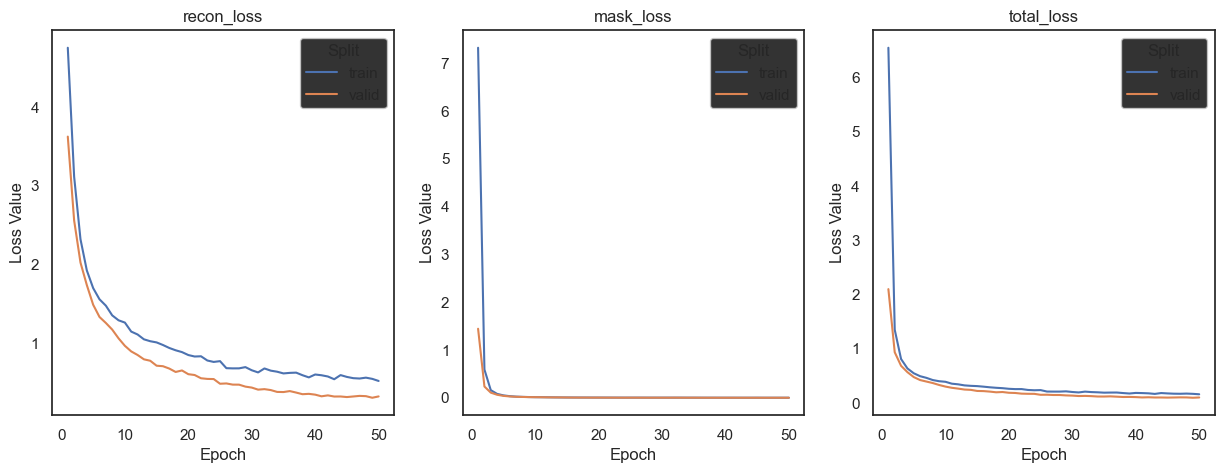

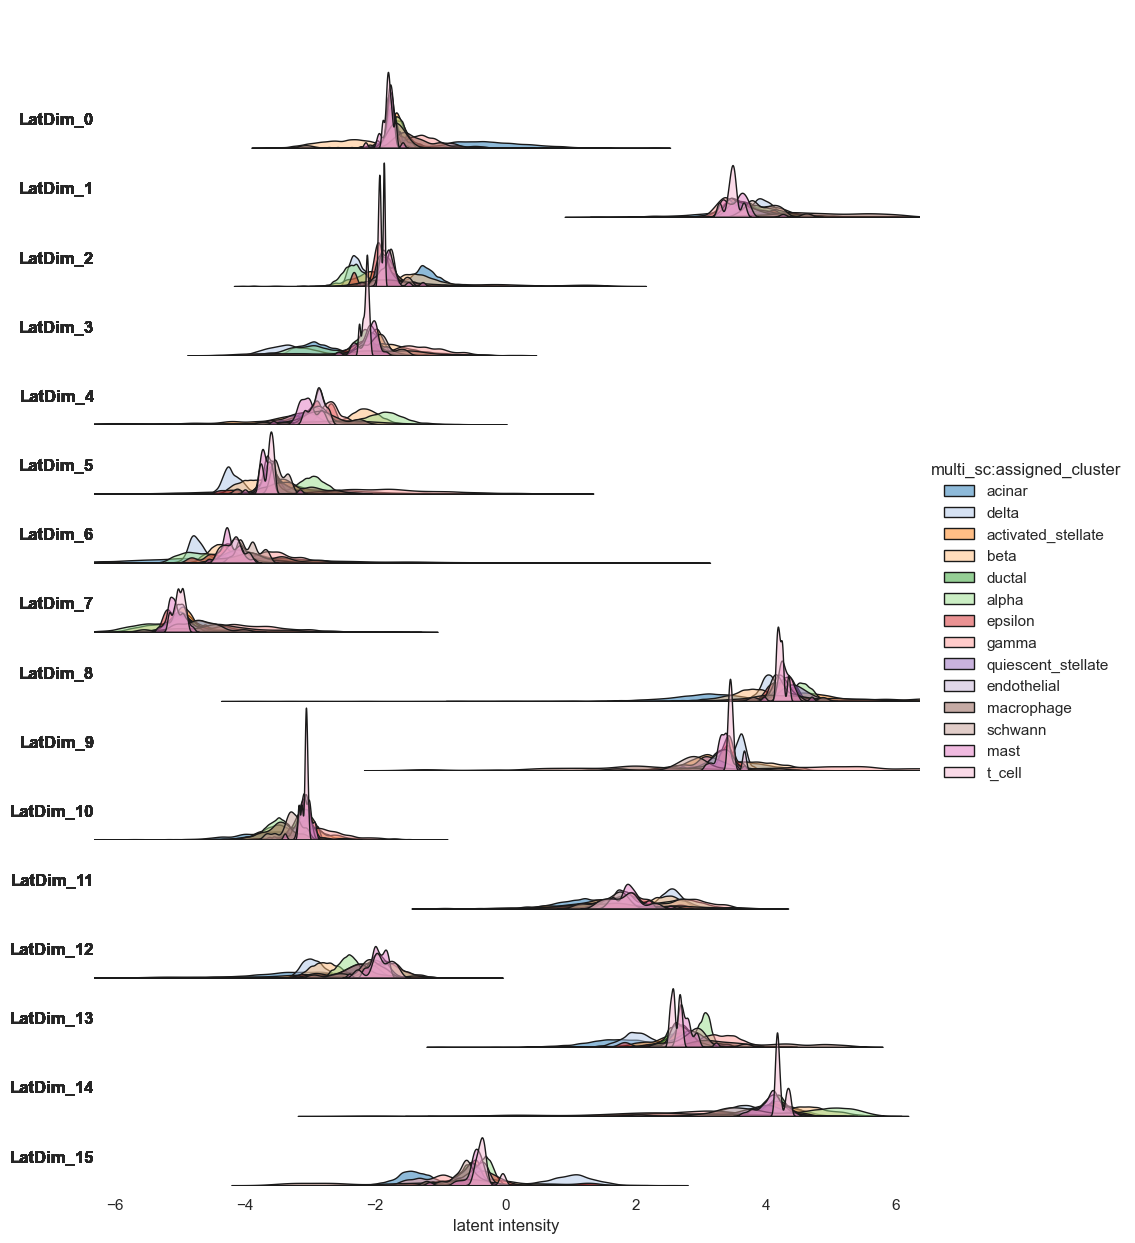

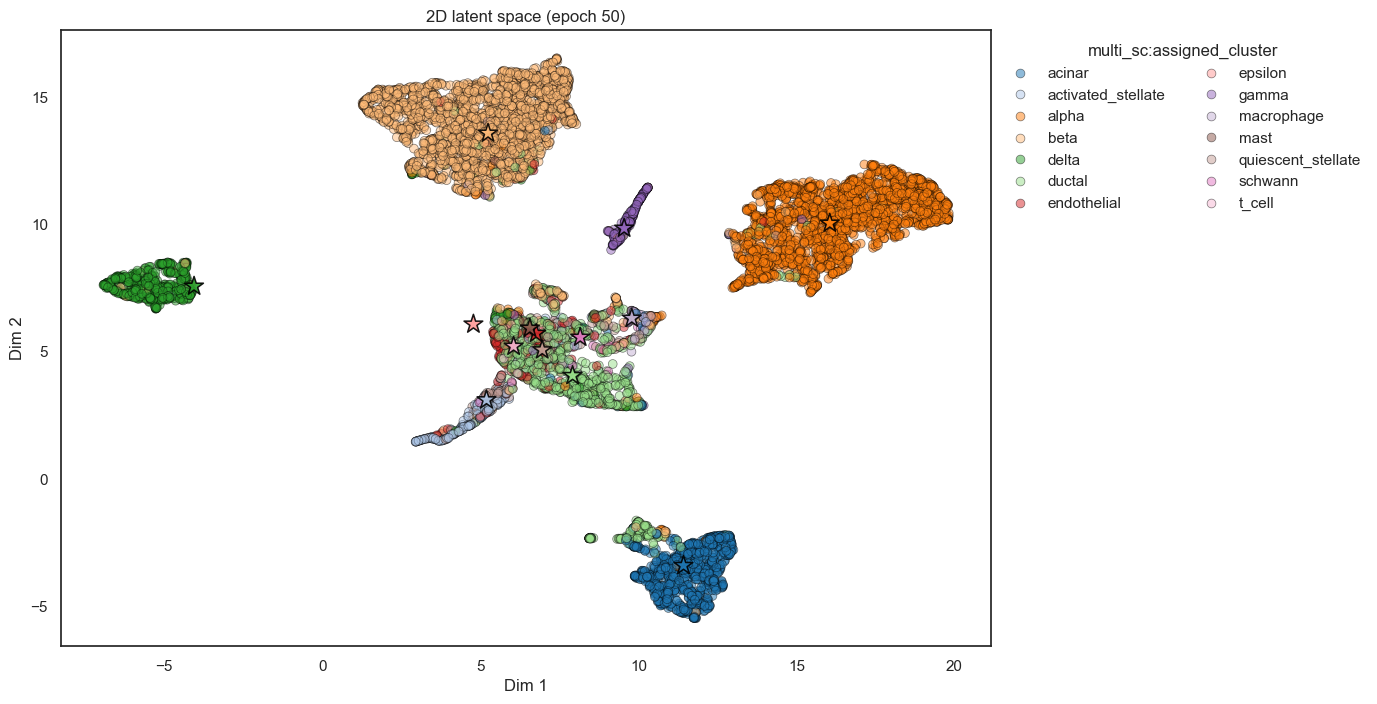

In [26]:
maskix_zero = pipelines["0.0"]
maskix_zero.show_result()

Creating plots ...


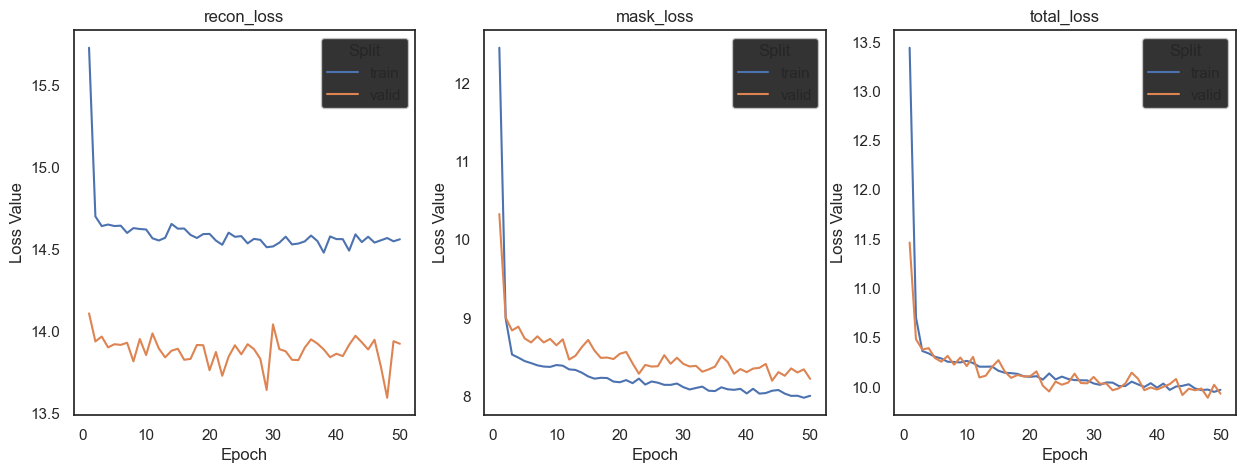

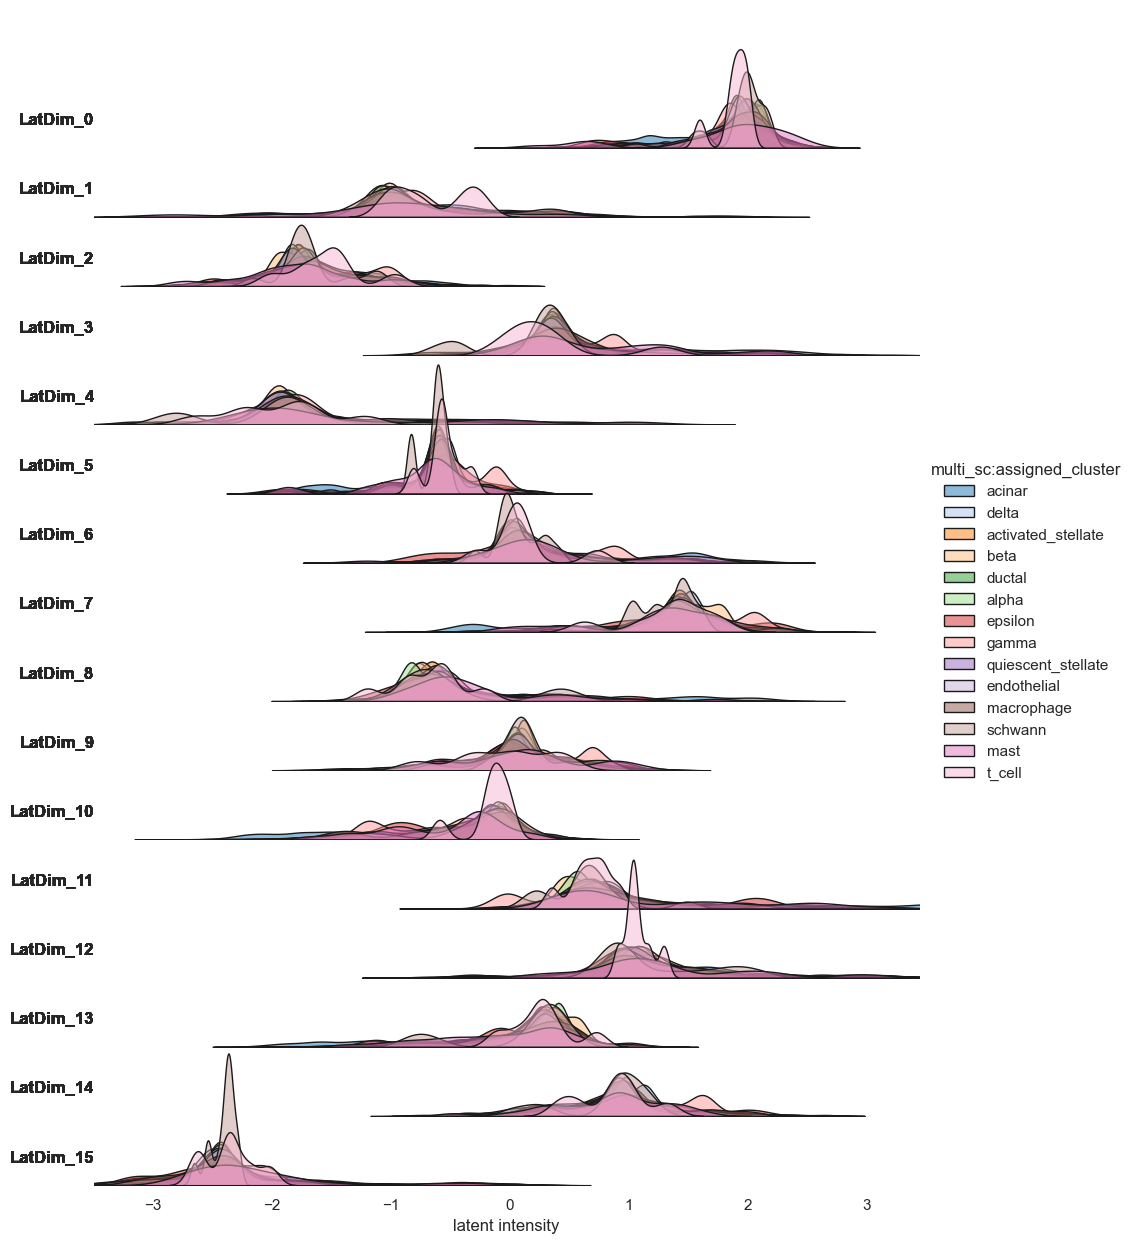

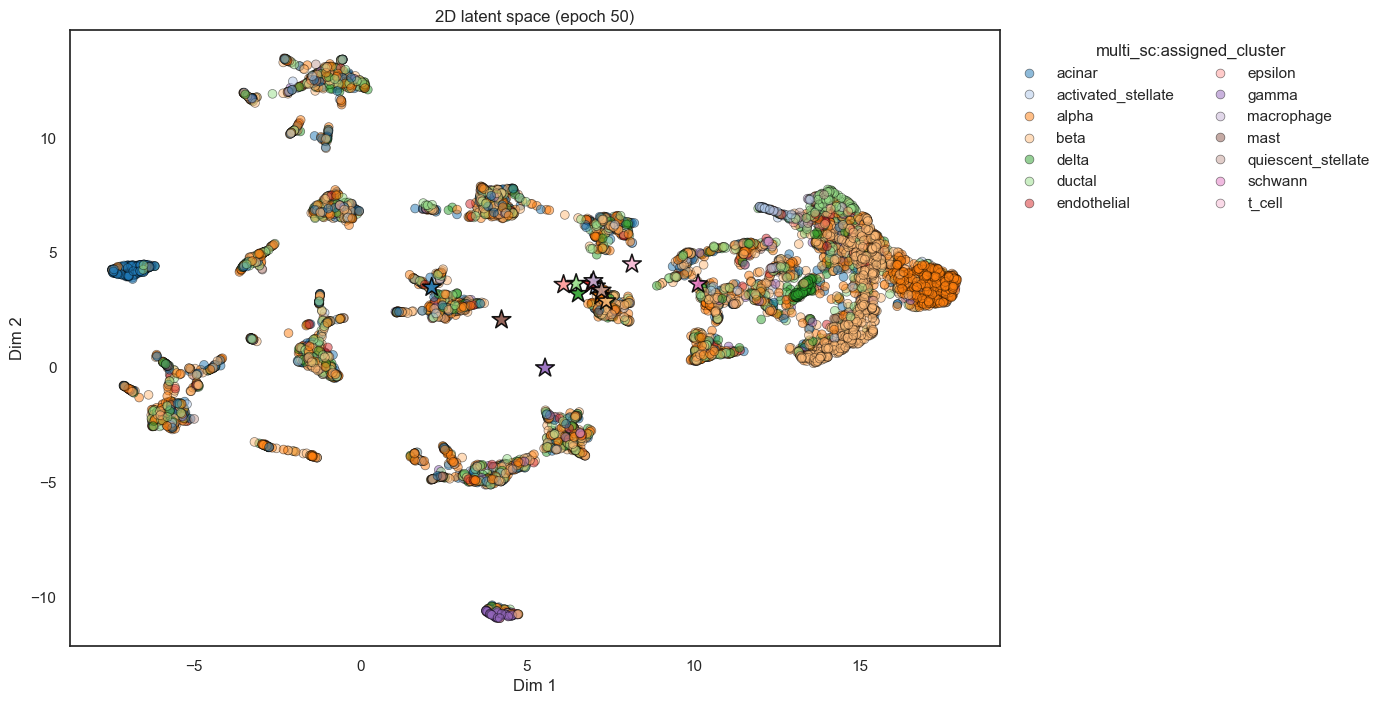

In [27]:
maskix_zero = pipelines["1.0"]
maskix_zero.show_result()

Creating plots ...


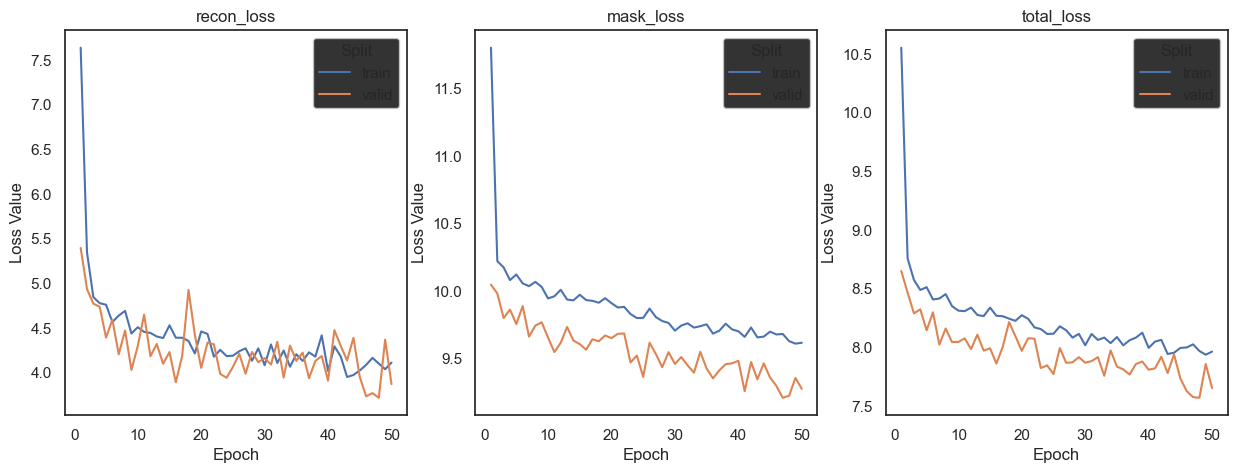

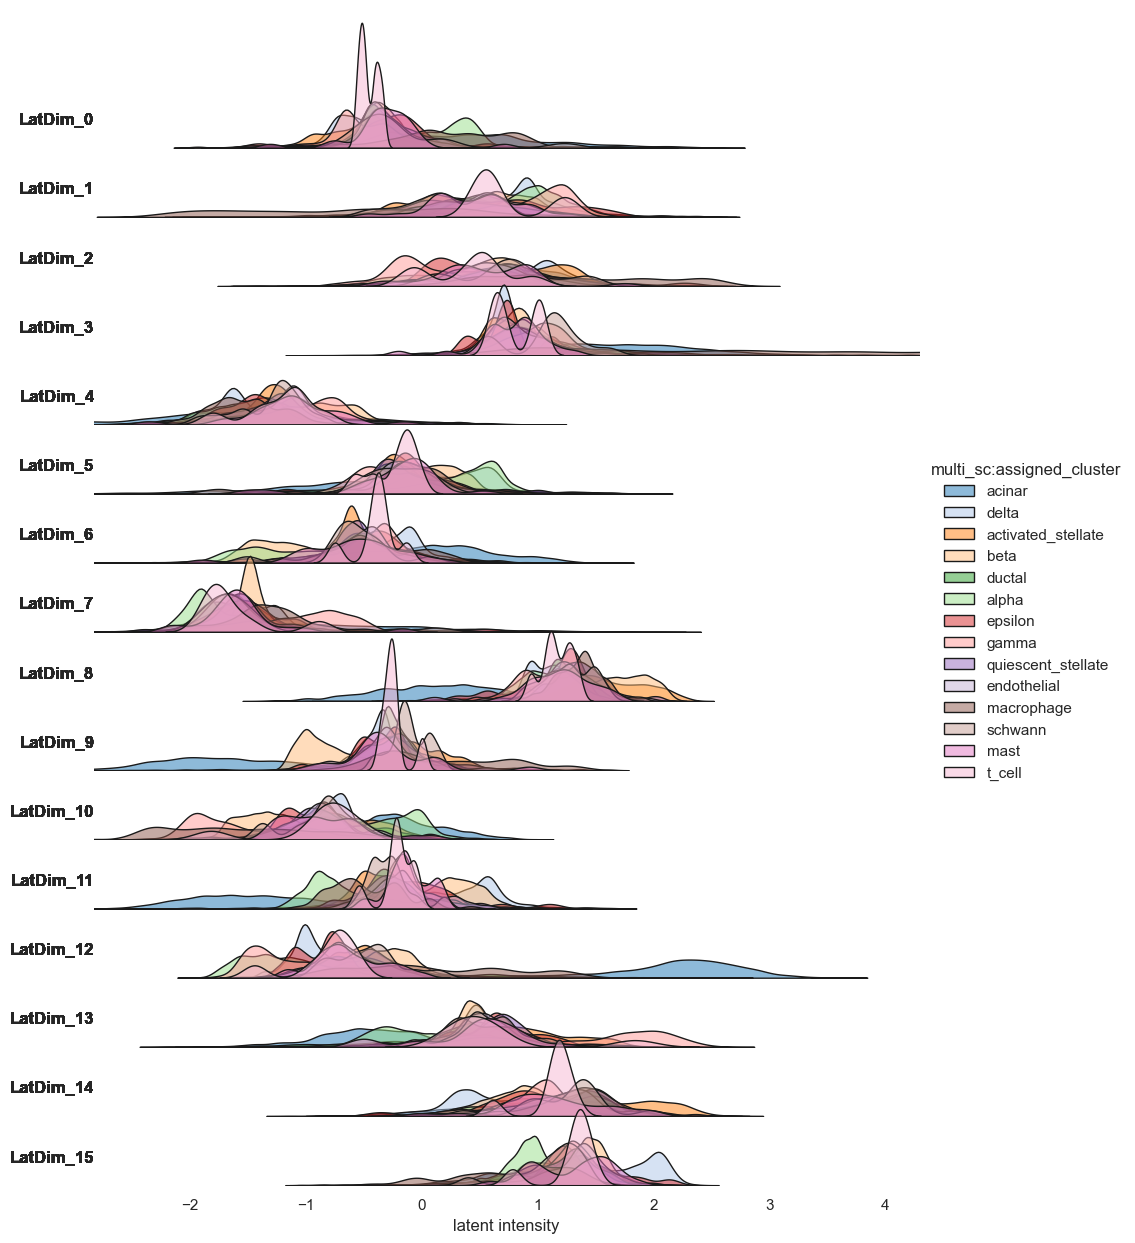

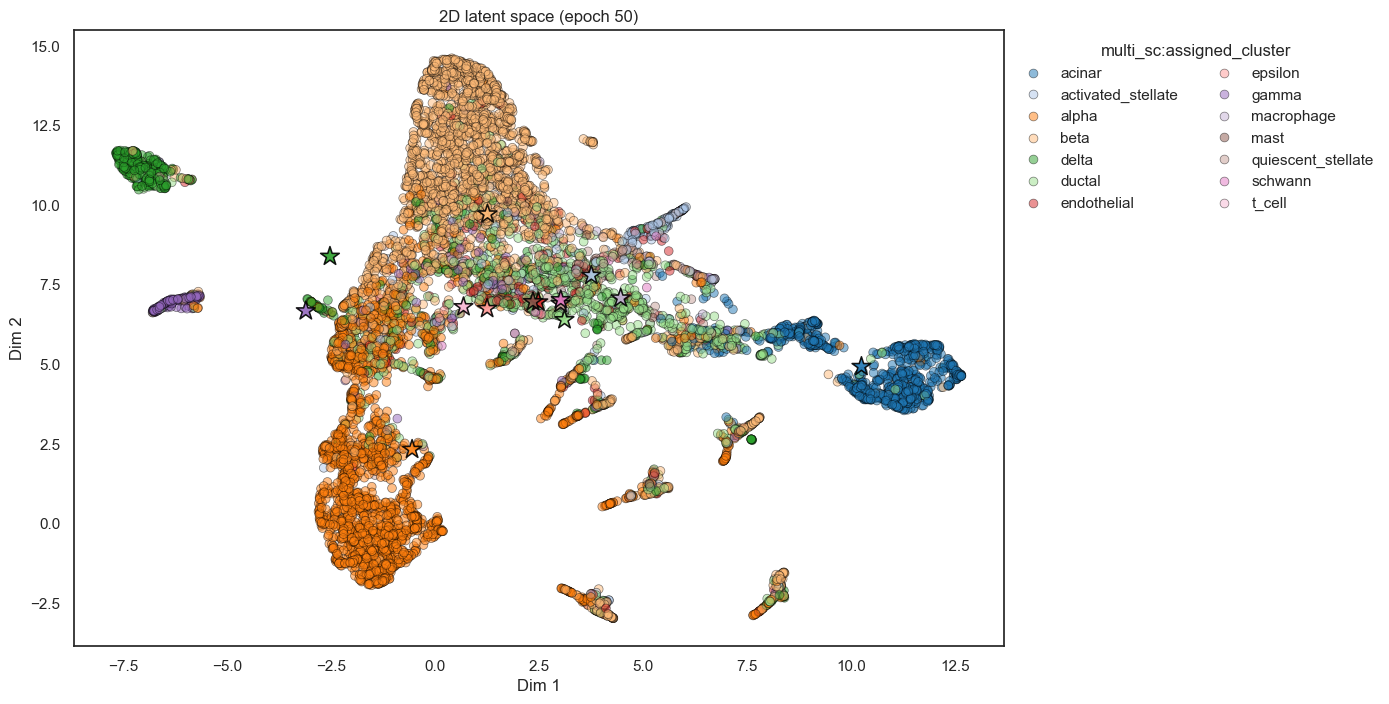

In [28]:
maskix_zero = pipelines["0.3"]
maskix_zero.show_result()

Creating plots ...


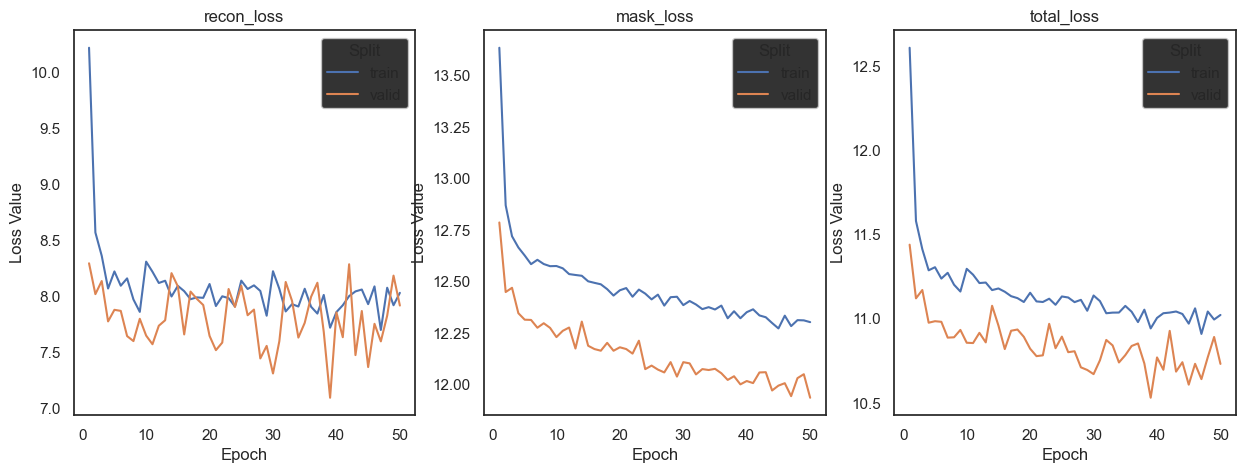

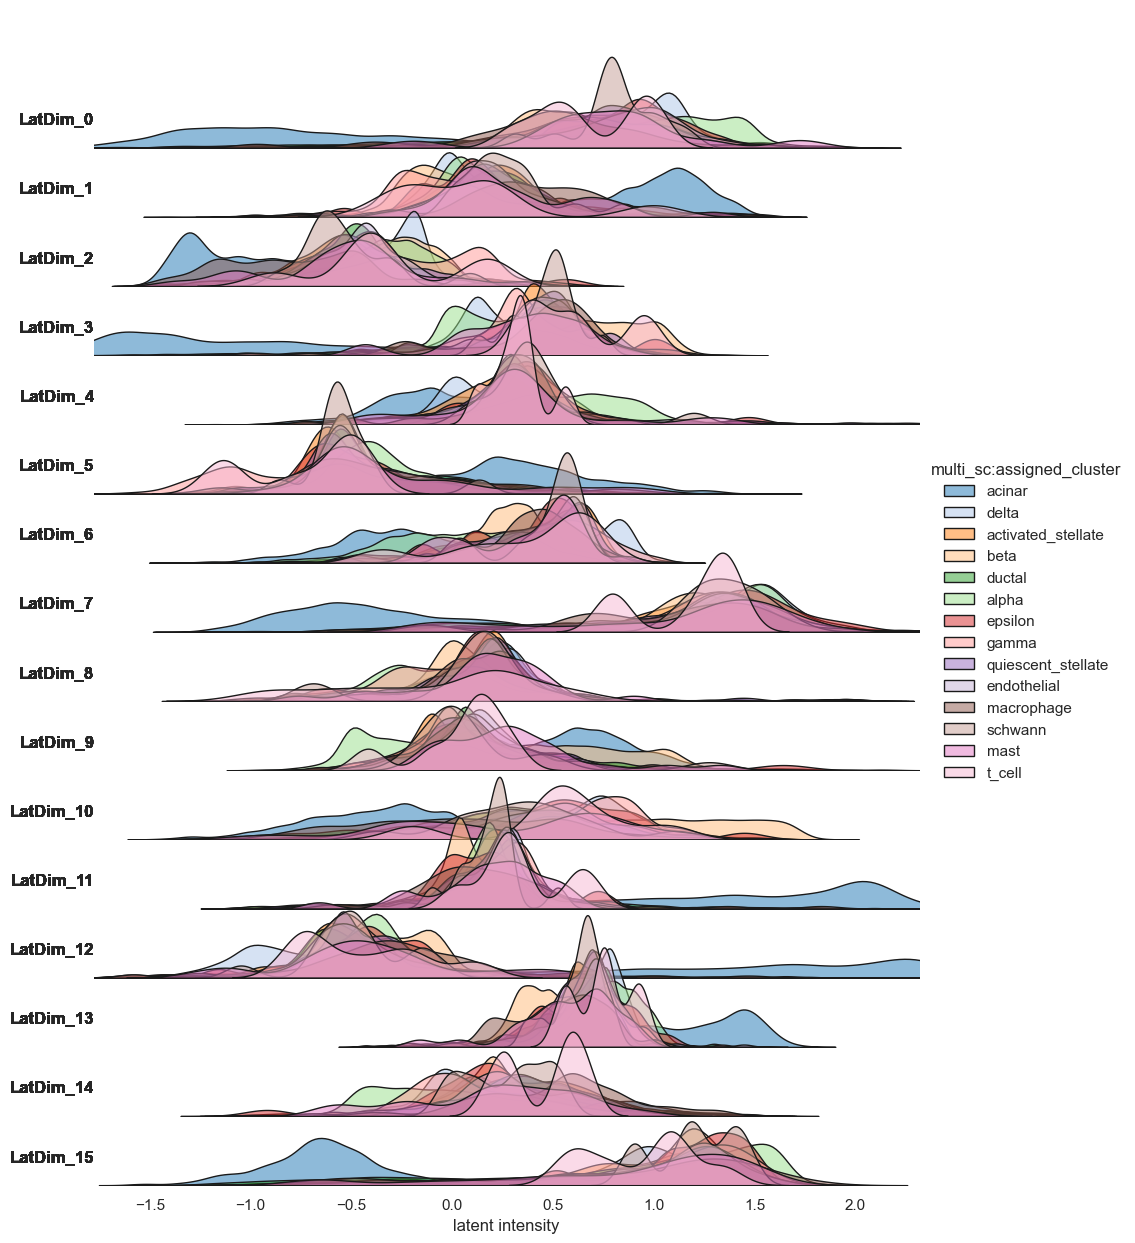

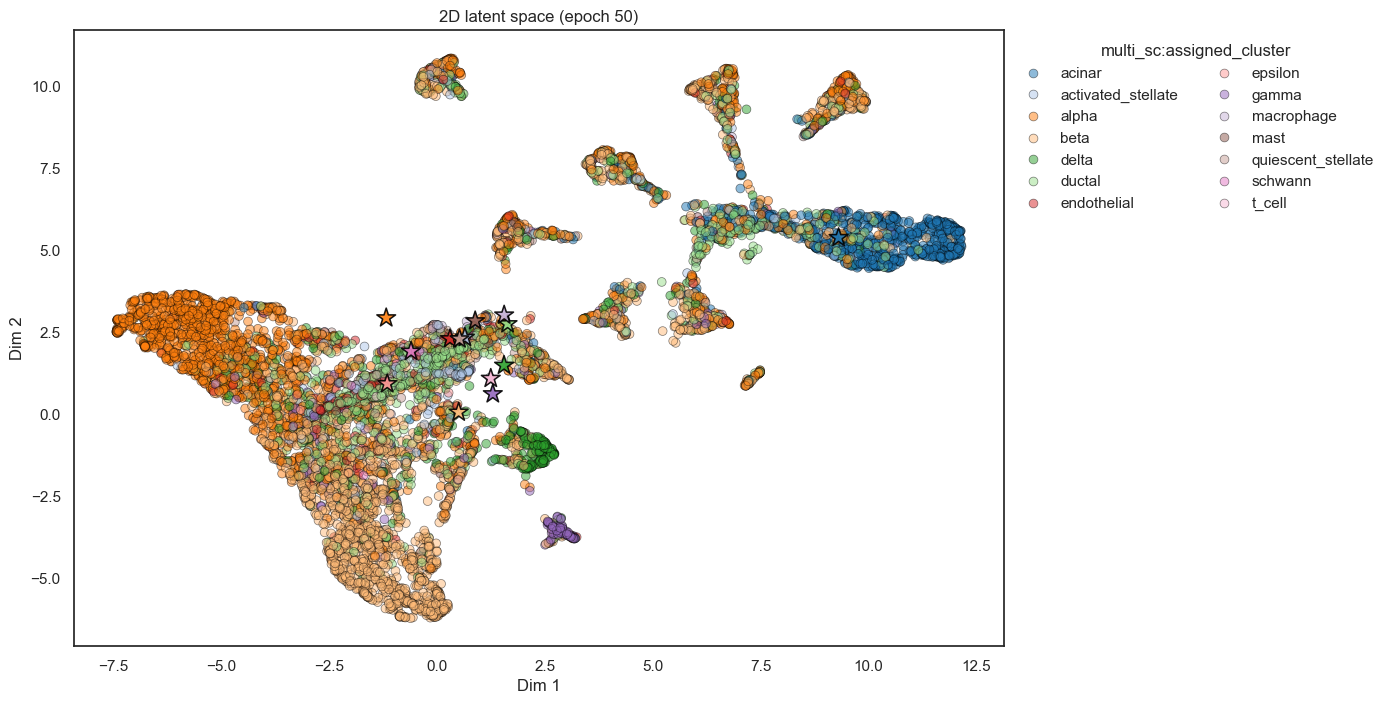

In [29]:
maskix_zero = pipelines["0.6"]
maskix_zero.show_result()

## Adding a Custom Masking Function to `MaskixTrainer`

`MaskixTrainer` supports replacing its default corruption mechanism with a user-defined masking function. This enables experimentation with alternative masking strategies while ensuring compatibility with the trainer’s data flow.

## How to Add a Custom Masking Function

Provide your masking function at initialization:

```python
# We assume that config is defined and other imports are done (see above)

def my_masking_fn(x: torch.Tensor, strength: float = 0.2):
    noise = torch.randn_like(x) * strength
    return x + noise  # must return ONLY a single tensor in shape of input tensor

masking_fn_kwargs = {"strength": 0.1}
maskix = acx.Maskix(config=config, masking_fn, masking_fn_kwargs
)
```
## Requirements for a Custom Masking Function

A custom masking function must satisfy the following constraints:

1. **It must accept a `torch.Tensor` as the first positional argument.**  
   The trainer passes the input mini-batch `X` directly into the function.

2. **It must return exactly one value: a `torch.Tensor`.**  
   The trainer does not consume or propagate additional outputs.  
   Returning tuples or multiple values is not allowed.

3. **The returned tensor must have the same shape as the input tensor.**  
   Any shape mismatch will raise a validation error.

4. **The function must operate on the device of the input tensor.**  
   The function must not assume the tensor resides on the CPU; it must operate on the device of `x`.

5. **Any additional parameters must be passed via `masking_fn_kwargs`.**  
   These keyword arguments provide a clean separation between trainer configuration and masking logic.

### Example
This is our default masking method:
```python
    def _maskix_hook(
        self, X: torch.Tensor
    ) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        # expand probablities for bernoulli sampling to match input shape
        probs = self._mask_probas.expand(X.shape)

        # Create the Boolean Mask (1 = Swap, 0 = Keep)
        should_swap = torch.bernoulli(probs).bool()

        # COLUMN-WISE SHUFFLING
        # We generate a random float matrix and argsort it along dim=0.
        # This gives us independent random indices for every column.
        rand_indices = torch.rand(X.shape, device=X.device).argsort(dim=0)

        # Use gather to reorder X based on these random indices
        shuffled_X = torch.gather(X, 0, rand_indices)
        corrupted_X = torch.where(should_swap, shuffled_X, X)

        return corrupted_X
```



In [2]:
import torch
import autoencodix as acx
from autoencodix.configs import MaskixConfig
from autoencodix.configs.default_config import DataInfo, DataConfig, DataCase


def my_masking_fn(x: torch.Tensor, strength: float = 0.2):
    # Noise is created with the same shape, dtype, and device as `x`
    noise = torch.randn_like(x) * strength
    return x + noise
kwargs = {"strength": 0.5}



sc_path = os.path.join("data/raw", "GSE84133_human_combined_final.h5ad")
config = MaskixConfig(
    epochs=5,
    checkpoint_interval=2,
    batch_size=64,
    data_config=DataConfig(
        annotation_columns=["multi_sc:assigned_cluster"],
        data_info={
            "multi_sc": DataInfo(
                file_path=sc_path, is_single_cell=True, data_type="NUMERIC"
            )
        },
    ),
    data_case=DataCase.MULTI_SINGLE_CELL)
maskix = acx.Maskix(config=config, masking_fn=my_masking_fn, masking_fn_kwargs=kwargs)

In [3]:
result = maskix.run()

Number of common cells: 8569
Index(['barcode', 'assigned_cluster', 'sample_id'], dtype='object')
mudata: View of MuData object with n_obs × n_vars = 8569 × 20125
  obs:	'barcode', 'assigned_cluster', 'sample_id'
  1 modality
    multi_sc:	8569 x 20125
      obs:	'barcode', 'assigned_cluster', 'sample_id'
Processing 1 MuData objects: ['multi_sc']
Processing train modality: multi_sc
Processing valid split
Processing valid modality: multi_sc
Processing test split
Processing test modality: multi_sc


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/losses/maskix_loss.py:38: UserWarning: You chose loss reduction: sum, this deviates from the implementation in the literature for this architecture, the authors used 'mean'
  warnings.warn(


<function my_masking_fn at 0x13f2c45e0>
Masking function output shape: torch.Size([100, 30])
Masking function input shape: torch.Size([100, 30])
Epoch 1 - Train Loss: 9.3374
Sub-losses: recon_loss: 6.8484, mask_loss: 10.4042
Using user-defined masking function.
Using user-defined masking function.
Using user-defined masking function.
Using user-defined masking function.
Using user-defined masking function.
Using user-defined masking function.
Using user-defined masking function.
Using user-defined masking function.
Using user-defined masking function.
Using user-defined masking function.
Using user-defined masking function.
Using user-defined masking function.
Using user-defined masking function.
Using user-defined masking function.
Epoch 1 - Valid Loss: 28.2903
Sub-losses: recon_loss: 10.7440, mask_loss: 35.8101
Epoch 2 - Train Loss: 7.0102
Sub-losses: recon_loss: 4.3256, mask_loss: 8.1608
Using user-defined masking function.
Using user-defined masking function.
Using user-defined mas